In [8]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib for better visuals
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
pokemon_df = pd.read_csv('data/pokemon_dataset.csv', index_col=0)
moves_df = pd.read_csv('data/move_dataset.csv', index_col=0) # All Pokemon moves minus banned ones.
learnset_df = pd.read_csv('data/learnset_dataset.csv', index_col=0) # Matrix of whether Pokemon can learn move or not (only Pokemon with >=4 movesets)


In [10]:
# Filter for moves that exist in learnset matrix.
moves_df = moves_df.loc[[int(i) for i in learnset_df.columns]]


roles = ["Physical Sweeper", "Special Sweeper", "Tank", "Mixed Sweeper", "Drainer", "Hybrid"]


# What each type (row) is weak against (column types).
type_effectiveness_matrix = [
    [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,],
    [1, 0.5, 2, 1, 0.5, 0.5, 1, 1, 2, 1, 1, 0.5, 2, 1, 1, 1, 0.5, 0.5,],
    [1, 0.5, 0.5, 2, 2, 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1,],
    [1, 1, 1, 0.5, 1, 1, 1, 1, 2, 0.5, 1, 1, 1, 1, 1, 1, 0.5, 1,],
    [1, 2, 0.5, 0.5, 0.5, 2, 1, 2, 0.5, 2, 1, 2, 1, 1, 1, 1, 1, 1,],
    [1, 2, 1, 1, 1, 0.5, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0.5, 0.5, 1, 1, 0.5, 1, 2,],
    [1, 1, 1, 1, 0.5, 1, 0.5, 0.5, 2, 1, 2, 0.5, 1, 1, 1, 1, 1, 0.5,],
    [1, 1, 2, 0, 2, 2, 1, 0.5, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1,],
    [1, 1, 1, 2, 0.5, 2, 0.5, 1, 0, 1, 1, 0.5, 2, 1, 1, 1, 1, 1,],
    [1, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 0.5, 2, 1, 2, 1, 2, 1, 1,],
    [1, 2, 1, 1, 0.5, 1, 0.5, 1, 0.5, 2, 1, 1, 2, 1, 1, 1, 1, 1,],
    [0.5, 0.5, 2, 1, 2, 1, 2, 0.5, 2, 0.5, 1, 1, 1, 1, 1, 1, 2, 1,],
    [0, 1, 1, 1, 1, 1, 0, 0.5, 1, 1, 1, 0.5, 1, 2, 1, 2, 1, 1,],
    [1, 0.5, 0.5, 0.5, 0.5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,],
    [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0.5, 1, 0.5, 1, 2,],
    [0.5, 2, 1, 1, 0.5, 0.5, 2, 0, 2, 0.5, 0.5, 0.5, 0.5, 1, 0.5, 1, 0.5, 0.5,],
    [1, 1, 1, 1, 1, 1, 0.5, 2, 1, 1, 1, 0.5, 1, 1, 0, 0.5, 2, 1]
]

## 1. Create Role Score Dataset


role_weights = {
    "Physical Sweeper": {
        "HP": 0.3,  # Slight survivability
        "Attack": 1.5,  # Highest priority on raw attack power
        "SpAttack": 0.1,  # Minimal special attack importance
        "Speed": 1.2,  # High importance on speed to strike first
        "Defense": 0.4,  # Some defensive capability
        "SpDefense": 0.3  # Minimal special defense
    },
    "Special Sweeper": {
        "HP": 0.3,  # Slight survivability
        "Attack": 0.1,  # Minimal physical attack importance
        "SpAttack": 1.5,  # Highest priority on special attack power
        "Speed": 1.2,  # High importance on speed to strike first
        "Defense": 0.3,  # Minimal physical defense
        "SpDefense": 0.4  # Some special defensive capability
    },
    "Tank": {
        "HP": 1.5,  # Extreme emphasis on total health
        "Attack": 0.2,  # Minimal offensive capability
        "SpAttack": 0.2,  # Minimal special offensive capability
        "Speed": 0.3,  # Low speed priority
        "Defense": 1.2,  # High physical defense
        "SpDefense": 1.2  # High special defense
    },
    "Mixed Sweeper": {
        "HP": 0.4,  # Balanced survivability
        "Attack": 1,  # Strong physical attack
        "SpAttack": 1,  # Strong special attack
        "Speed": 1,  # Balanced speed
        "Defense": 0.3,  # Minimal physical defense
        "SpDefense": 0.3  # Minimal special defense
    },
    "Drainer": {
        "HP": 1.2,  # High health for sustained combat
        "Attack": 0.3,  # Minimal physical attack
        "SpAttack": 0.3,  # Minimal special attack
        "Speed": 0.4,  # Low speed priority
        "Defense": 1,  # Strong physical defense
        "SpDefense": 1  # Strong special defense
    },
    "Hybrid": {
        "HP": 1,
        "Attack": 1,
        "SpAttack": 1,
        "Speed": 1,
        "Defense": 1,
        "SpDefense": 1
    }
}

In [15]:
def compute_role_score(row, weights):
    return sum(row[stat] * weight for stat, weight in weights.items())


for role, weights in role_weights.items():
    pokemon_df[f"RoleScore_{role}"] = pokemon_df.apply(lambda row: compute_role_score(row, weights), axis=1)

In [16]:
role_move_preferences = {
    "Physical Sweeper": ["Earthquake", "Aerial Ace", "Rock Slide", "Brick Break", "Return", "Sludge Bomb", "Shadow Ball", "Belly Drum", "Swords Dance", "Bulk Up", "Dragon Dance"],
    "Special Sweeper": ["Thunderbolt", "Surf", "Ice Beam", "Flamethrower", "Psychic", "Dragon Claw", "Crunch", "Calm Mind", "Rain Dance", "Sunny Day"],
    "Tank": [
        "Acid Armor", "Acupressure", "Ancient Power", "Barrier", "Bulk Up", "Clangorous Soul", 
        "Clangorous Soulblaze", "Coil", "Cosmic Power", "Cotton Guard", "Curse", "Defend Order", 
        "Defense Curl", "Diamond Storm", "Extreme Evoboost", "Flower Shield", "Harden", "Iron Defense", 
        "Max Steelspike", "No Retreat", "Ominous Wind", "Order Up", "Psyshield Bash", "Shelter", 
        "Silver Wind", "Skull Bash", "Steel Wing", "Stockpile", "Stuff Cheeks", "Victory Dance", "Withdraw"
    ],
    "Mixed Sweeper": ["Earthquake", "Thunderbolt", "Surf", "Ice Beam", "Aerial Ace", "Rock Slide", "Brick Break","Swords Dance", "Calm Mind", "Dragon Dance", "Bulk Up"],
    "Drainer": [
        "Absorb", "Bitter Blade", "Bouncy Bubble", "Drain Punch", "Draining Kiss", "Dream Eater", 
        "Giga Drain", "Horn Leech", "Leech Life", "Leech Seed", "Matcha Gotcha", "Mega Drain", 
        "Oblivion Wing", "Parabolic Charge"
    ],
    "Hybrid": []
}
role_type_preferences = {
    "Tank": ["Normal", "Steel", "Fairy", "Fighting", "Ghost"],
    "Hybrid": ["Steel", "Fairy", "Fire", "Water", "Dark"],
    "Drainer": ["Grass", "Fairy", "Fighting", "Flying", "Bug"]
}
role_class_preferences = {
    "Physical Sweeper": ["Physical"],
    "Special Sweeper": ["Special"],
    "Tank": ["Physical", "Special", "Other"],
    "Mixed Sweeper": ["Physical", "Special"],
    "Drainer": ["Physical", "Special", "Other"],
    "Hybrid": ["Physical", "Special", "Other"]
}


def compute_role_move_score(move, role):
    score = 0
    for role_move in role_move_preferences[role]:
        if move["Name"].casefold() in role_move.casefold():
            score += 0.4
            break
    if move["Type"] in role_type_preferences.get(role, []):
        score += 0.3
    if move["Class"] in role_class_preferences[role]:
        score += 0.3
    
    score *= move["Power"] * (move["Accuracy"]/101)
    return score


for role in roles:
    moves_df[f"Effectiveness_{role}"] = moves_df.apply(lambda move: compute_role_move_score(move, role), axis=1)

role_move_scores = moves_df[["Name", "Effectiveness_Physical Sweeper", "Effectiveness_Special Sweeper", "Effectiveness_Tank", "Effectiveness_Mixed Sweeper", "Effectiveness_Drainer", "Effectiveness_Hybrid"]]
for role in roles:
    role_move_scores = role_move_scores.rename(columns={f"Effectiveness_{role}": role})

# ## 3. Prepare Datasets


# Label each role column in mdata as 1 if the move is best representative of a role and 0 otherwise.
effectiveness_columns = [f"Effectiveness_{role}" for role in roles]
max_effectiveness = moves_df[effectiveness_columns].max(axis=1)
for role, col in zip(roles, effectiveness_columns):
    moves_df[role] = (moves_df[col] == max_effectiveness).astype(int)

moves_df = moves_df.drop(columns=effectiveness_columns)


# Get types.
types = list(pokemon_df.columns[-24:-6])


# Get resistances and weaknesses.
type_resistances = {p: {t: int(pokemon_df.loc[p, t] < 1) for t in types} for p in pokemon_df.index}
type_weaknesses = {p: {t: int(pokemon_df.loc[p, t] > 1) for t in types} for p in pokemon_df.index}


# Get which type is effective against other types.
super_effective_types = {a: {t: int(type_effectiveness_matrix[types.index(t)][types.index(moves_df.loc[a]['Type'])] > 1) for t in types} for a in moves_df.index}


# STAB calculation
stab = {p: {a: int(moves_df.loc[a, 'Type'] in [pokemon_df.loc[p, 'Type1'], pokemon_df.loc[p, 'Type2']]) for a in moves_df.index} for p in pokemon_df.index}


In [ ]:
weights = np.linspace(0, 1, 11)  # Weights from 0 to 1 in increments of 0.1
f1_values = []
f2_values = []
objective_values = []

for weight in weights:
    filename = f'teams/team_={round(weight, 6)}.csv'
    try:
        # Load the team data for the current weight
        team_data = pd.read_csv(filename, header=None)
        team_data.columns = ['Pokemon'] + [f'Move{i+1}' for i in range(4)] + ['Role']
        
        # Calculate f1 (Role Scores)
        f1 = 0
        for _, row in team_data.iterrows():
            pokemon_id = row['Pokemon']
            print("Pokemon ID:", pokemon_id)
            role = row['Role']
            print("Role:", role)
            f1 += pokemon_df.loc[pokemon_id, f"RoleScore_{role}"]
            print(f1)
        
        # Calculate f2 (Move Effectiveness)
        f2 = 0
        for _, row in team_data.iterrows():
            pokemon_id = row['Pokemon']
            role = row['Role']
            moves = row[1:5]  # Moves for this Pokémon
            # print(moves[0], role)
            for move_id in moves:
                stab_bonus = 1 + 0.5 * stab[pokemon_id][move_id]
                # print(stab_bonus, role_move_scores.loc[move_id, role])
                f2 += stab_bonus * role_move_scores.loc[move_id, role]
                print(f2)
        # Compute weighted objective value
        objective_value = weight * f1 + (1 - weight) * f2
        
        # Store results
        f1_values.append(f1)
        f2_values.append(f2)
        objective_values.append(objective_value)
    except FileNotFoundError:
        print(f"Results file for weight={round(weight, 6)} not found.")
        f1_values.append(None)
        f2_values.append(None)
        objective_values.append(None)


Pokemon ID: 53
Role: Hybrid
510
Pokemon ID: 164
Role: Hybrid
1020
Pokemon ID: 313
Role: Hybrid
1545
Pokemon ID: 400
Role: Hybrid
2033
Pokemon ID: 520
Role: Hybrid
2533
Pokemon ID: 719
Role: Hybrid
3068
53.46534653465346
120.29702970297029
173.76237623762376
253.96039603960395
298.5148514851485
369.8019801980198
488.3168316831683
604.1584158415841
657.6237623762376
724.4554455445543
776.5841584158414
895.0990099009899
948.5643564356434
1019.8514851485147
1086.6831683168316
1138.8118811881186
1192.277227722772
1244.4059405940593
1300.5445544554455
1354.009900990099
1407.4752475247524
1525.9900990099009
1641.8316831683167
1668.5643564356433
Pokemon ID: 53
Role: Hybrid
510
Pokemon ID: 164
Role: Hybrid
1020
Pokemon ID: 313
Role: Hybrid
1545
Pokemon ID: 400
Role: Hybrid
2033
Pokemon ID: 520
Role: Hybrid
2533
Pokemon ID: 719
Role: Hybrid
3068
53.46534653465346
120.29702970297029
173.76237623762376
253.96039603960395
298.5148514851485
369.8019801980198
488.3168316831683
604.1584158415841
657.6

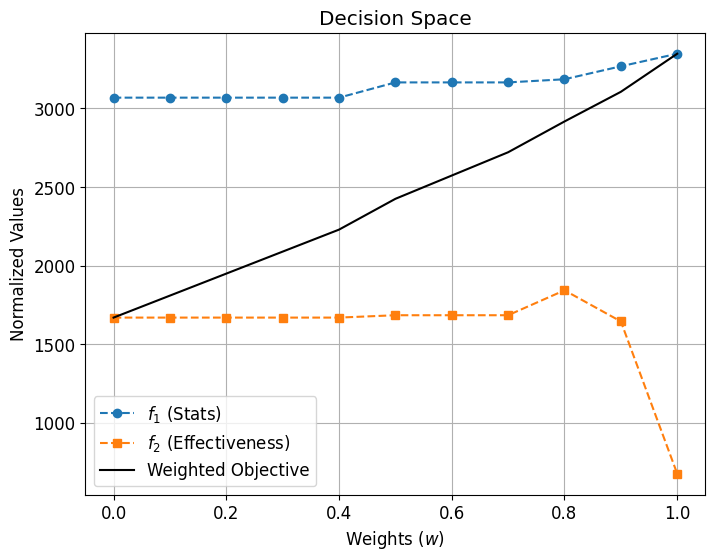

In [44]:
# Plot the decision space
plt.figure()
plt.plot(weights, f1_values, 'o--', label='$f_1$ (Stats)')
plt.plot(weights, f2_values, 's--', label='$f_2$ (Effectiveness)')

# Weighted objective function
weighted_objective = [
    w * f1 + (1 - w) * f2 
    for w, f1, f2 in zip(weights, f1_values, f2_values)
    if f1 is not None and f2 is not None
]
plt.plot(weights, weighted_objective, 'k-', label='Weighted Objective')

# Add labels and legend
plt.title('Decision Space')
plt.xlabel('Weights ($w$)')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Filter out None values for plotting
valid_f1 = [f for f in f1 if f is not None]
valid_f2 = [f for f in f2 if f is not None]

# Plot the Pareto front (Objective Space)
plt.figure()
plt.plot(valid_f1, valid_f2, 'o-', label='Pareto Front')

# Add labels and legend
plt.title('Objective Space')
plt.xlabel('Normalized $f_1$ (Stats)')
plt.ylabel('Normalized $f_2$ (Effectiveness)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Analyze teams for a specific weight (example: weight = 0.5)
weight_to_analyze = 0.5
filename = f'teams/team_={round(weight_to_analyze, 6)}.csv'
try:
    team_data = pd.read_csv(filename, header=None)
    team_data.columns = ['Pokemon'] + [f'Move{i+1}' for i in range(4)]
    print("Selected Team and Moves for weight =", weight_to_analyze)
    display(team_data)
except FileNotFoundError:
    print(f"Results file for weight={round(weight_to_analyze, 6)} not found.")
